# Concert Exploration

This uses my personal concert attendance dataset. It has been input by hand over a course of years and may need some cleaning in order to filter and learn more.

The definition of a `show` for the purposes of this dataset is:
> Any unique grouping of an Artist, Date and Location.

For example `('Man Man', '2007-10-06', 'Hamilton College, Clinton, NY')` is a single show, as is the opening act `('Grizzly Bear', '2007-10-06', 'Hamilton College, Clinton, NY')` .

Since openers and headliners count individually as shows, some of the counts may be inflated at first. We'll work to come up with combined concert statistics later on.

In [696]:
%matplotlib inline
import pandas as pd, pytz
import numpy as np
import matplotlib.pyplot as plt, matplotlib.font_manager as fm

# define the fonts to use for plots
family = 'Helvetica Neue'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [697]:
# By Geoff Boeing
# https://github.com/gboeing/data-visualization/blob/master/lastfm-listening-history/lastfm_analysis.ipynb
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

In [698]:
# Feed in the list
shows = pd.read_csv('concerts.csv')

# Standardize the dates
shows['Date'] = pd.to_datetime(shows['Date'])
print('Shows Attended:', len(shows))

Shows Attended: 649


## Extract Location Data
The **Location** column should be in a standard format `"<Venue>, <City>, <State>"`. If not, we'll need to fix the location values to be in this format. Once all location info is standardized, we will split it into the three subcolumns.

In [699]:
# Clean up Location Data
def get_city(item):
    loc = item.split(', ')
    if (len(loc) > 1):
        return ', '.join(loc[1:])
    else:
        return np.NaN

def append_ny(venue):
    ny_venues = ['Webster Hall', 'Bowery Ballroom', 'Mercury Lounge', 'Hammerstein Ballroom', 'Roseland Ballroom', 'Irving Plaza', 'Carnegie Hall', 'Central Park Summerstage', 'Terminal 5', 'Playstation Theater', 'Radio City Music Hall', 'Governor\'s Ball', 'Le Poisson Rouge', 'Slake', 'Pier 84', 'Pianos', 'Rockwood Music Hall', 'Highline Ballroom', 'Rocks Off Boat Cruise', 'NYU Skirball', 'NYU Kimmel Center']
    bk_venues = ['Brooklyn Bowl', 'Music Hall of Williamsburg', 'Music hall of Williamsburg', 'Cameo Gallery', '285 Kent Ave', 'Red Hook Park', 'House of Vans', 'Williamsburg Waterfront', 'Prospect Park Bandshell', 'Dirtybird BBQ', 'Brooklyn Masonic Temple']
    venue = venue.strip()
    if (venue in ny_venues):
        return ', '.join([venue, 'New York', 'NY'])
    if (venue in bk_venues):
        return ', '.join([venue, 'Brooklyn', 'NY'])
    return venue
    
shows['Location'] = shows['Location'].apply(lambda x: append_ny(x))

venues = {
    "Utica Auditorium": "Utica Auditorium, Utica, NY", 
    "Stanley Theatre": "Stanley Theatre, Utica, NY", 
    "Hamilton College": "Hamilton College, Clinton, NY",
    "Bowery Ballroom NYC": "Bowery Ballroom, New York, NY",
    "Best Buy Theater": "Playstation Theater, New York, NY",  
    "Turning Stone Casino":  "Turning Stone Casino, Verona, NY",
    "University of Rochester":  "University of Rochester, Rochester, NY",
    "Bonnaroo 2009": "Bonnaroo, Manchester, TN",
    "Camp Bisco 8": "Camp Bisco, Mariaville, NY",
    "Camp Bisco 10": "Camp Bisco, Mariaville, NY",
    "Camp Bisco 12": "Camp Bisco, Mariaville, NY",
    "Camp Bisco 13": "Camp Bisco, Scranton, PA",
    "Camp Bisco": "Camp Bisco, Scranton, PA",
    "Somerville Theatre": "Somerville Theatre, Somerville, MA",
    "Tufts University": "Tufts University, Somerville, MA",
    "Saranac Brewery": "Saranac Brewery, Utica, NY",
    "Glasslands NYC": "Glasslands, Brooklyn, NY",
    "Firefly Music Festival": "Firefly Music Festival, Dover, DE",
    "Big Up 2": "The Big Up, Claverack, NY",
    "SPAC": "SPAC, Saratoga, NY",
    "Pianos NYC": "Pianos, New York, NY",
    "Prospect Park": "Prospect Park Bandshell, Brooklyn, NY",
    "Propsect Park": "Prospect Park Bandshell, Brooklyn, NY",
    "Orpheum Theatre": "Orpheum Theatre, Boston, MA",
    "Grammercy Theatre": "Gramercy Theatre, New York, NY",
    "Colgate University": "Colgate University, Hamilton, NY",
    "285 Kent ave": "285 Kent Ave, Brooklyn, NY",
    "Cambridge YMCA Theatre": "Cambridge YMCA Theatre, Cambridge, MA",
    "Rebel NYC": "Club Rebel, New York, NY",
    "Portchester NY": "Capitol Theatre, Port Chester, NY",
    "College in Bronx": "Lehman College, Bronx, NY",
    "Bushwick Warehouse": "Unicorn Meat, Brooklyn, NY",
    "Saugerties, NY": "Hudson Music Project, Saugerties, NY",
    "East River Park, NY": "East River Park, New York, NY",
    "CMJ": "Public Assembly, Brooklyn, NY",
    "Red Rocks, CO": "Red Rocks, Morrison, CO",
    "Loew's Theatre, NJ": "Loew's Theatre, Jersey City, NJ",
    "River Stage at Great Plaza Philadelphia, Pennsylvania": "River Stage at Great Plaza, Philadelphia, PA"
}
shows = shows.replace({'Location': venues})

# Split Location to get Venue and City
shows['Venue'] = shows['Location'].apply(lambda x: x.split(', ')[0].title())
# Clean up City Names to add State/Province
shows['City'] = shows['Location'].apply(lambda x: get_city(x))
cities = { 
    "NYC": "New York, NY", "Greenpoint": "Brooklyn, NY", "Sunset Park, Brooklyn, NY ": "Brooklyn, NY", "Brooklyn ": "Brooklyn, NY", "Brooklyn": "Brooklyn, NY", "Williamsburg": "Brooklyn, NY",
    "Utica": "Utica, NY", "Chicago": "Chicago, IL", "Syracuse": "Syracuse, NY", "Boston": "Boston, MA", "New York": "New York, NY", "Randall's Island NYC": "New York, NY", "Ridgewood NY": "Ridgewood, NY", 
    "Sunset Park, Brooklyn, NY": "Brooklyn, NY", "Rochester": "Rochester, NY", "Ithaca": "Ithaca, NY", "Albany": "Albany, NY", "Toronto": "Toronto, ON", "Hancock NY": "Hancock, NY"
}
shows = shows.replace({'City': cities})

# Use to find invalid structure locations remaining
# shows[pd.isnull(shows['Location'])]['Location']
def get_state(item):
    loc = item.split(', ')
    if (len(loc) > 1):
        return loc[1]

shows['State'] = shows['City'].apply(lambda x: get_state(x))
shows['City'] = shows['City'].apply(lambda x: x.split(', ')[0])

convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Eastern'))
get_year = lambda x: convert_tz(x).year
shows['Year'] = shows['Date'].map(get_year)

shows.head()

,Artist,Date,Location,Attended With,Notes,Venue,City,State,Year
0,Trey Anastasio,2002-10-05,"Stanley Theatre, Utica, NY",Lisa Schapiro,NaN,Stanley Theatre,Utica,NY,2002
1,Nickelback,2003-11-01,"Utica Auditorium, Utica, NY",NaN,NaN,Utica Auditorium,Utica,NY,2003
2,Three Days Grace,2003-11-01,"Utica Auditorium, Utica, NY",NaN,NaN,Utica Auditorium,Utica,NY,2003
3,Trapt,2003-11-01,"Utica Auditorium, Utica, NY",NaN,NaN,Utica Auditorium,Utica,NY,2003
4,Hoobastank,2004-01-17,"Worcester Centrum Centre, Boston",Lisa Schapiro,NaN,Worcester Centrum Centre,Boston,MA,2004


## Cleaned Up Shows List

In [700]:
# Relevant Parts
shows[['Artist', 'Date', 'Venue', 'City', 'State']].head()

,Artist,Date,Venue,City,State
0,Trey Anastasio,2002-10-05,Stanley Theatre,Utica,NY
1,Nickelback,2003-11-01,Utica Auditorium,Utica,NY
2,Three Days Grace,2003-11-01,Utica Auditorium,Utica,NY
3,Trapt,2003-11-01,Utica Auditorium,Utica,NY
4,Hoobastank,2004-01-17,Worcester Centrum Centre,Boston,MA


## Get Total Show Counts

In [701]:
def get_count(df, period):
    return df.set_index('Date').resample(period).size()

def plot_counts(period_counts, title='', xlabel='', ylabel='', color='blue'):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.plot(
        period_counts.keys().to_pydatetime(), 
        period_counts.values,
        color=color
    )

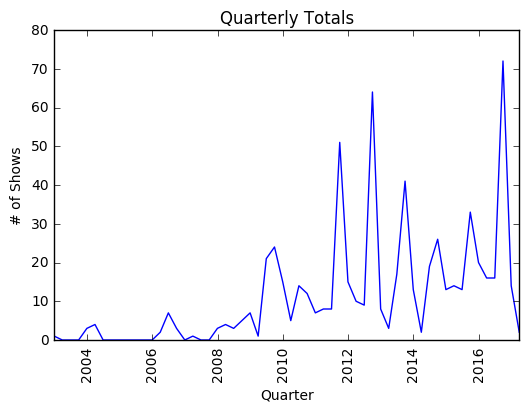

In [702]:
quarterly = get_count(shows, "Q")
yearly = get_count(shows, "A")
last_four = quarterly[-16:]
plot_counts(quarterly, title='Quarterly Totals', xlabel='Quarter', ylabel='# of Shows')

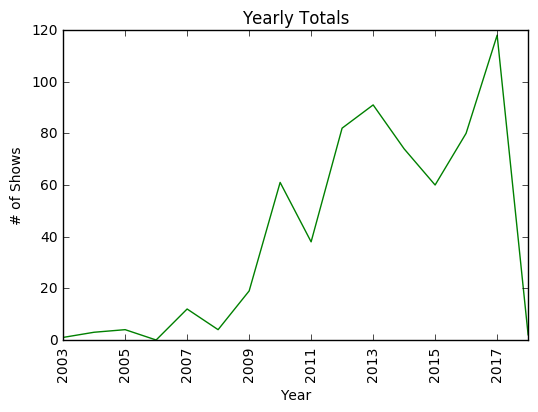

In [703]:
yearly = get_count(shows, "A")
plot_counts(yearly, title='Yearly Totals', xlabel='Year', ylabel='# of Shows', color='green')

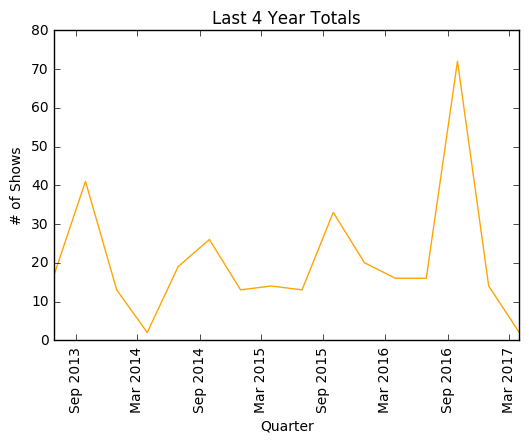

In [704]:
last_four = quarterly[-16:]
plot_counts(last_four, title='Last 4 Year Totals', xlabel='Quarter', ylabel='# of Shows', color='orange')

## Top Venues, Cities & States
Some of these cities and venues are inflated by festivals that were attended there. Since each gig counts individually, many are clumped around a single festival.

In [705]:
# Top City Info
print('Top 10 Cities:')
shows.groupby('City').size().sort_values(ascending=False)[:10]

Top 10 Cities:


City
New York       212
Brooklyn       106
Mariaville      53
Montreal        39
Boston          24
Burning Man     23
Manchester      20
Chicago         19
Claverack       18
Saugerties      16
dtype: int64

In [706]:
# Top State Info
print('Top 5 States:')
shows.groupby('State').size().sort_values(ascending=False)[:5]

Top 5 States:


State
NY        474
Quebec     39
MA         29
NV         23
TN         20
dtype: int64

In [707]:
# Top Venues
print('Top 25 Venues:')
shows.groupby('Venue').size().sort_values(ascending=False)[:25]

Top 25 Venues:


Venue
Camp Bisco                    68
Osheaga                       39
Governor'S Ball               33
Panorama Festival             27
Terminal 5                    23
Webster Hall                  20
Bonnaroo                      20
Pitchfork Fest 2011           19
Music Hall Of Williamsburg    19
The Big Up                    18
Hamilton College              16
Hudson Music Project          16
Firefly Music Festival        12
Bowery Ballroom               10
Best Buy Theater               9
Playstation Theater            8
Brooklyn Bowl                  8
Camp Questionmark              7
Irving Plaza                   7
Glasslands                     7
B-Sides Fest                   6
Pianos                         6
East River Park                6
Root Society                   6
Knitting Factory               5
dtype: int64

## Matching with Last.fm Data
Grabbed my personal last.fm scrobble information (@yono) using `benfoxall/lastfm-to-csv` which is leased under the MIT License

In [708]:
lfm = pd.read_csv('last_fm.csv', header=0, names=['Artist', 'Album', 'Song', 'Date'])
artists = lfm.groupby('Artist').size()
top_artists = artists[artists > 20].sort_values(ascending=False)

## Summary Listening Values

In [709]:
# Get Summary Values
print('Songs Scrobbled:', len(lfm))
print('Total Unique Artists:', len(artists))
# Cut out those < 20 plays
print('Unique Listened Artists:', len(top_artists))

Songs Scrobbled: 118983
Total Unique Artists: 5607
Unique Listened Artists: 793


## Top Artists

In [710]:
# Get Top Artists
print('Top 25 Artists:')
top_artists.head(25)

Top 25 Artists:


Artist
of Montreal                 3248
Animal Collective           2416
Belle and Sebastian         1647
Neutral Milk Hotel          1400
The Shins                   1203
Arcade Fire                 1190
Modest Mouse                1162
The Beatles                 1154
Badly Drawn Boy             1026
Broken Social Scene          996
Kanye West                   995
Death Cab for Cutie          990
The New Pornographers        836
Black Moth Super Rainbow     776
Architecture in Helsinki     750
Boards of Canada             722
Vampire Weekend              707
Neon Indian                  703
Shpongle                     672
Baths                        660
Girl Talk                    639
Crystal Fighters             639
Guster                       603
Cake                         598
Yeasayer                     592
dtype: int64

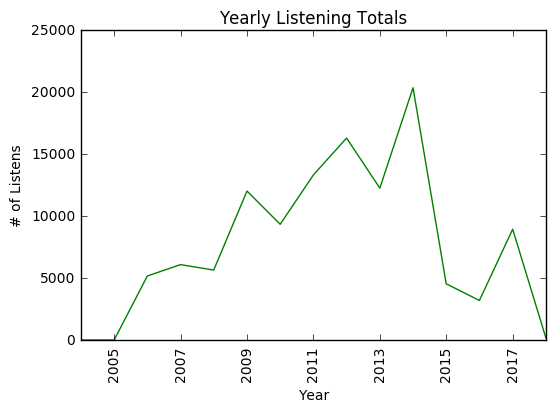

In [711]:
lfm['Date'] = pd.to_datetime(lfm['Date'])
yearly_listens = get_count(lfm, "A")[-15:]
plot_counts(yearly_listens, title='Yearly Listening Totals', xlabel='Year', ylabel='# of Listens', color='green')

## Which of my top artists have I seen live?

In [712]:
top_scrobble_artists = list(top_artists.head(25).keys().values)
seen_live_artists = shows['Artist'].unique()

def seen_top_artists(top_artists, seen_artists):
    intersect_with_key = lambda s1, s2, key=lambda i: i: set(map(key, s1)).intersection(map(key, s2))
    seen_top = intersect_with_key(top_artists, seen_artists, key=str.lower)
    return list(map(lambda x: x.title(), seen_top))

def unseen_top_artists(top_artists, seen_artists):
    intersect_with_key = lambda s1, s2, key=lambda i: i: set(map(key, s1)).intersection(map(key, s2))
    seen_top = intersect_with_key(top_artists, seen_artists, key=str.lower)
    scrobble_caseless = set(map(lambda x: x.lower(), top_artists))
    return list(map(lambda x: x.title(), scrobble_caseless - seen_top))

seen_top = seen_top_artists(top_scrobble_artists, seen_live_artists)
unseen_top = unseen_top_artists(top_scrobble_artists, seen_live_artists)

print('I have seen {} of my top {} artists.'.format(len(seen_top), 25))
print('Of my favorites, I have not yet seen:', ', '.join(unseen_top))

I have seen 21 of my top 25 artists.
Of my favorites, I have not yet seen: Boards Of Canada, The Beatles, Badly Drawn Boy, The New Pornographers


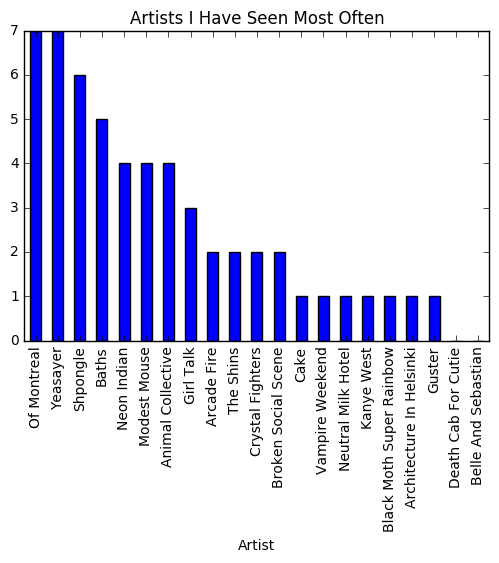

In [720]:
#top_seen_counts()
seen_counts = shows.groupby('Artist').size()
top_seen_counts = seen_counts.loc[seen_top].sort_values(ascending=False)
top_seen_counts.plot(kind="bar", title='Artists I Have Seen Most Often')

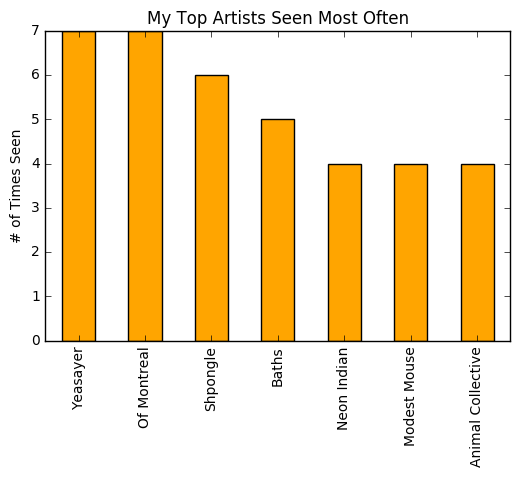

In [714]:
# Favorite Artists I Have Seen Most Often
most_seen = seen_counts.sort_values(ascending=False).head(21)
seen_totals = pd.concat([most_seen, top_seen_counts], axis=1)
seen_totals.columns = ['Seen Most Often', 'Top Listened']
# seen_totals['Is Top Seen'] = seen_totals[]
# seen_totals
favorite_seen = seen_totals[seen_totals.isin(seen_totals.dropna()) == True].dropna()['Seen Most Often'].sort_values(ascending=False)
favorite_seen.plot(kind='bar', color='orange', title="My Top Artists Seen Most Often").set_ylabel("# of Times Seen")

## Which Time of Year do I See Most Concerns?
Prediction: Summer!

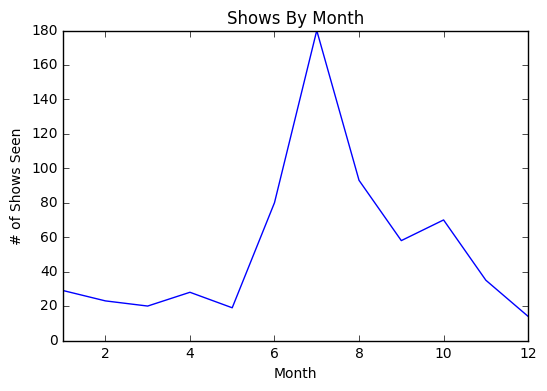

In [715]:
period_shows = shows.set_index('Date')
period_shows['Month'] = period_shows.index.month
period_shows['Month'] = period_shows['Month']
period_counts = period_shows.groupby('Month').size()
period_counts.plot(kind="line", title="Shows By Month").set_ylabel("# of Shows Seen")

In [716]:
period_counts

Month
1      29
2      23
3      20
4      28
5      19
6      80
7     180
8      93
9      58
10     70
11     35
12     14
dtype: int64

## Festivals vs. Concerts

In [717]:
festivals = set(['Bonnaroo', 'B-Sides Fest', 'Catskill Chill', 'Camp Bisco', 'Dirtybird BBQ', 'Elements Festival', 'Firefly Music Festival', 'Hudson Music Project', 'Governor\'S Ball', 'Big Up', 'The Big Up', 'Pitchfork Fest 2011', 'Osheaga', 'Panorama Festival'])
# not_festivals = set(shows['Venue']) - festivals
not_festivals = shows.loc[~shows['Venue'].isin(list(festivals))]
top_ten_nonfest_venues = not_festivals.groupby('Venue').size().sort_values(ascending=False).head(10)
top_venues = top_ten_nonfest_venues.index.tolist()
top_ten_nonfest_venue_shows = shows.loc[shows['Venue'].isin(list(top_venues))]
top_ten_nonfest_venue_shows.head()

,Artist,Date,Location,Attended With,Notes,Venue,City,State,Year
10,Belle Orchestre,2006-04-25,"Hamilton College, Clinton, NY",NaN,NaN,Hamilton College,Clinton,NY,2006
13,Chromeo,2006-04-29,"Hamilton College, Clinton, NY",Sarah Yoss;Ben Hicks,"Spring Fest, first time, they were just two gu...",Hamilton College,Clinton,NY,2006
14,Elf Power,2006-04-29,"Hamilton College, Clinton, NY",Sarah Yoss;Ben Hicks,NaN,Hamilton College,Clinton,NY,2006
15,New Pornographers,2006-04-29,"Hamilton College, Clinton, NY",Sarah Yoss;Ben Hicks,Second time,Hamilton College,Clinton,NY,2006
20,Of Montreal,2007-03-07,"Hamilton College, Clinton, NY",NaN,First time seeing them,Hamilton College,Clinton,NY,2007


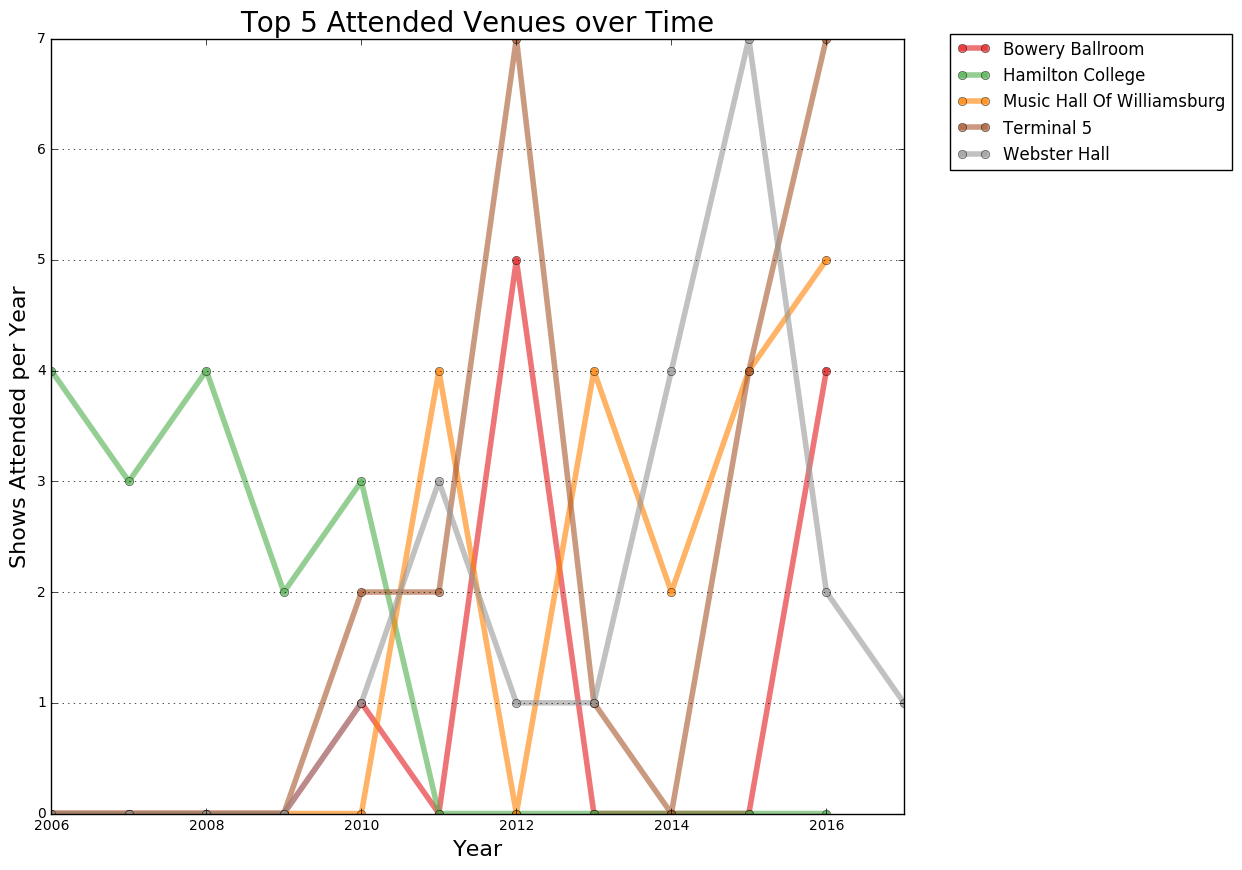

In [738]:
# get the cumulative play counts since 2009 for the top n most listened-to artists
n = 5
shows_year = shows[shows['Venue'].isin(top_venues[:5])]
shows_year = shows_year.groupby(['Venue','Year']).size() #.groupby(level=[0]) #.cumsum()['track']
plot_venues = shows_year.index.levels[0]

# Set Default to Fill in 0s if no shows attended in a year
default = pd.Series(0, pd.date_range('1/1/2006', periods=11, freq='A').map(get_year))

# get one color per artist
colors = get_colors('Set1', n)

fig, ax = plt.subplots(figsize=[11, 10])
lines = []
for venue, c in zip(plot_venues, colors):
    merged_year = shows_year[venue].combine(default, lambda x, y: x + y, fill_value=0)
    ax = merged_year.plot(kind='line', linewidth='4', alpha=0.6, marker='o', color=c)
    lines.append(venue)
    
ax.yaxis.grid(True)
ax.set_ylabel('Shows Attended per Year', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_title('Top 5 Attended Venues over Time', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.395,1.017))
